In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
from closest import closest
from jpm_number_printing import latex_float

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def determine_preflare_irradiance(light_curve_df, estimated_time_of_peak_start, 
                                  max_median_diff_threshold=10.0, std_threshold=0.5, 
                                  plot_path_filename=None, verbose=False):
    """Determine pre-flare irradiance level in a solar light curve. 
    Or, more generally, find the pre-peak level in a time series.

    Inputs:
        light_curve_df [pd DataFrame]:           A pandas DataFrame with a DatetimeIndex and a column for irradiance.
        estimated_time_of_peak_start [metatime]: The estimated time that the dramatic increase starts. 
                                                 This could come from, e.g., GOES/XRS.
        
    Optional Inputs:
        max_median_diff_threshold [float]: The maximum allowed difference in medians between the 3 pre-flare windows
                                           in percent terms. The default is 10.
        std_threshold [float]:             The maximum allowed standard deviation in the pre-flare windows in percent
                                           terms. The default is 0.5. 
        plot_path_filename [str]:          Set to a path and filename in order to save the summary plot to disk.
                                           Default is None, meaning the plot will not be saved to disk.
        verbose [bool]:                    Set to log the processing messages to disk and console. Default is False.

    Outputs:
        preflare_irradiance [float]: The identified pre-flare irradiance level in the same units as light_curve_df.irradiance.
                                                 
    Optional Outputs:
        None

    Example:
        preflare_irradiance = determine_preflare_irradiance(light_curve_df, pd.Timestamp('2012-04-15 17:52:20.0'),
                                                            plot_path_filename='./bla.png',
                                                            verbose=True)
    """
    return 1

In [10]:
# prototype only: set up example inputs
%matplotlib inline
plt.style.use('jpm-transparent-light')
example_to_use = 'rising'

if example_to_use == 'oscillating':
    estimated_time_of_peak_start = pd.Timestamp('2012-04-15 21:20:00.0')  # oscillating light curve
elif example_to_use == 'rising':
    estimated_time_of_peak_start = pd.Timestamp('2011-02-16 14:20:00.0')  # rising light curve
else:
    estimated_time_of_peak_start = pd.Timestamp('2011-02-16 15:20:00.0')  # with prior flare

max_median_diff_threshold = 10.0
std_threshold = 0.5
plot_path_filename = './bla.png'
verbose = True

from scipy.io.idl import readsav
if example_to_use == 'oscillating':
    idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Dimming Light Curve.sav')
    irradiance = idl_generated_data.irradiance[:, 3].byteswap().newbyteorder() # Not sure why this is big endian but pandas plotting needs it to be little
    light_curve_df = pd.DataFrame({'irradiance_percent': irradiance})
    light_curve_df['irradiance'] = light_curve_df['irradiance_percent'] * 6.2e-5 + 6.2e-5 # It's already in % so converting back
    light_curve_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
elif example_to_use == 'rising':
    idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Pre-flare Light Curve 1.sav')
    irradiance = idl_generated_data.irradiance.byteswap().newbyteorder() # Not sure why this is big endian but pandas plotting needs it to be little
    light_curve_df = pd.DataFrame({'irradiance': irradiance, 
                                   'irradiance_percent': (irradiance - irradiance[0]) / irradiance[0] * 100.})
    light_curve_df.index = pd.to_datetime(idl_generated_data.time.astype(str))
else:
    idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Pre-flare Light Curve 2.sav')
    irradiance = idl_generated_data.irradiance.byteswap().newbyteorder() # Not sure why this is big endian but pandas plotting needs it to be little
    light_curve_df = pd.DataFrame({'irradiance': irradiance, 
                                   'irradiance_percent': (irradiance - irradiance[0]) / irradiance[0] * 100.})
    light_curve_df.index = pd.to_datetime(idl_generated_data.time.astype(str))

light_curve_df.head()

,irradiance,irradiance_percent
2011-02-16 12:00:13,0.000061,0.000000
2011-02-16 12:01:13,0.000062,0.407284
2011-02-16 12:02:13,0.000062,0.580749
2011-02-16 12:03:13,0.000062,0.392872
2011-02-16 12:04:13,0.000062,0.419690


In [11]:
# Prepare the logger for verbose
if verbose:
    # TODO: Update the path
    logger = JpmLogger(filename='determine_preflare_irradiance_log', path='/Users/jmason86/Desktop/')
    logger.info("Running on event with peak start time of {0}.".format(estimated_time_of_peak_start))

2017-12-28 12:54:56,246 [INFO ] [<module>] Running on event with peak start time of 2011-02-16 14:20:00.
2017-12-28 12:54:56,246 [INFO ] [<module>] Running on event with peak start time of 2011-02-16 14:20:00.


In [12]:
# Divide the pre-flare period into 3 equal-length windows
windows = np.array_split(light_curve_df[:estimated_time_of_peak_start], 3)
if verbose:
    logger.info("Divided pre-flare period into 3 equal-length windows.")

2017-12-28 12:54:56,583 [INFO ] [<module>] Divided pre-flare period into 3 equal-length windows.
2017-12-28 12:54:56,583 [INFO ] [<module>] Divided pre-flare period into 3 equal-length windows.


In [13]:
# Compute median and σ in each window
medians = [windowed_df['irradiance_percent'].median() for windowed_df in windows]
medians_abs = [windowed_df['irradiance'].median() for windowed_df in windows]
stds = np.array([windowed_df['irradiance_percent'].std() for windowed_df in windows])
if verbose:
    logger.info("Computed medians and standard deviations in each window.")

2017-12-28 12:54:56,925 [INFO ] [<module>] Computed medians and standard deviations in each window.
2017-12-28 12:54:56,925 [INFO ] [<module>] Computed medians and standard deviations in each window.


In [14]:
# Compute max difference between the medians
max_median_diff = np.max(np.abs(np.append(np.diff(medians), medians[2] - medians[0])))

# Compare medians and σs in each window to thresholds
failed_median_threshold = False
failed_std_threshold = False
if max_median_diff > max_median_diff_threshold:
    if verbose:
        logger.warning('Cannot compute pre-flare irradiance. Maximum difference in window medians ({0}) exceeded threshold ({1}).'.format(max_median_diff, max_median_diff_threshold))
    failed_median_threshold = True
if (stds < std_threshold).sum() < 2:
    if verbose:
        logger.warning('Cannot compute pre-flare irradiance. Standard deviation in more than 1 window is larger than threshold ({0}).'.format(std_threshold))
    failed_std_threshold = True

In [15]:
# Compute pre-flare irradiance (mean of the medians in absolute units)
if failed_median_threshold or failed_std_threshold:
    preflare_irradiance = None
else:
    preflare_irradiance = np.mean([windowed_df['irradiance'].median() for windowed_df in windows])
    if verbose:
        logger.info("Computed pre-flare irradiance: {0}".format(preflare_irradiance))

2017-12-28 12:54:59,013 [INFO ] [<module>] Computed pre-flare irradiance: 6.190403413105135e-05
2017-12-28 12:54:59,013 [INFO ] [<module>] Computed pre-flare irradiance: 6.190403413105135e-05


2017-12-28 12:55:24,185 [INFO ] [<module>] Summary plot for event with start time 2011-02-16 14:20:00 saved to ./bla.png
2017-12-28 12:55:24,185 [INFO ] [<module>] Summary plot for event with start time 2011-02-16 14:20:00 saved to ./bla.png


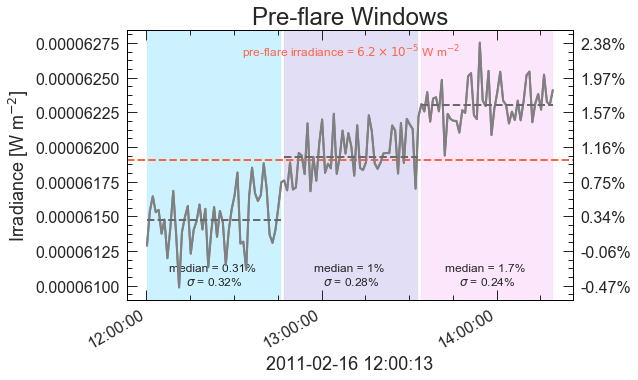

In [16]:
# Produce summary plot
if plot_path_filename:
    plt.style.use('jpm-transparent-light')
    from matplotlib import dates
    from matplotlib.patches import Rectangle
    
    light_curve_df = light_curve_df.drop('irradiance_percent', 1)
    ax = light_curve_df[:estimated_time_of_peak_start].plot(legend=False, c='grey')
    #plt.plot(light_curve_df[:estimated_time_of_peak_start].irradiance, c='grey')
    #ax = plt.gca()
    start_date = light_curve_df.index.values[0]
    start_date_string = pd.to_datetime(str(start_date))
    plt.title('Pre-flare Windows')
    plt.xlabel(start_date_string.strftime('%Y-%m-%d %H:%M:%S'))
    plt.ylabel('Irradiance [W m$^{-2}$]')
    fmtr = dates.DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(fmtr)
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax2 = ax.twinx()
    light_curve_df[:estimated_time_of_peak_start].plot(ax=ax2, legend=False, c='grey')
    #ax2.plot(light_curve_df[:estimated_time_of_peak_start].irradiance, color='grey')
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.2f}%'.format((x - light_curve_df.irradiance[0]) / light_curve_df.irradiance[0] * 100) 
                         for x in vals])

    # First window
    start = dates.date2num(light_curve_df.index[0])
    end = dates.date2num(windows[0].index[-1])
    width = end - start
    rect = Rectangle((start, 0), width, 1, color='deepskyblue', alpha=0.2)
    ax.add_patch(rect)
    plt.plot([windows[0].index[0], windows[0].index[-1]], [medians_abs[0], medians_abs[0]], 
             linestyle = 'dashed', c='dimgrey')
    ax.text(start + width / 2.0, np.min(light_curve_df[:estimated_time_of_peak_start].irradiance), 
            'median = ' + latex_float(medians[0]) + '% \n' + 
            '$\sigma$ = ' + latex_float(stds[0]) + '%', fontsize=12,
            ha='center', va='bottom')
    
    # Second window
    start = dates.date2num(windows[1].index[0])
    end = dates.date2num(windows[1].index[-1])
    width = end - start
    rect = Rectangle((start, 0), width, 1, color='slateblue', alpha=0.2)
    ax.add_patch(rect)
    ax4 = plt.plot([windows[1].index[0], windows[1].index[-1]], [medians_abs[1], medians_abs[1]], 
                   linestyle = 'dashed', c='dimgrey')
    ax.text(start + width / 2.0, np.min(light_curve_df[:estimated_time_of_peak_start].irradiance), 
             'median = ' + latex_float(medians[1]) + '% \n' + 
             '$\sigma$ = ' + latex_float(stds[1]) + '%', fontsize=12,
             ha='center', va='bottom')
    
    if preflare_irradiance:
        ax.axes.axhline(y=preflare_irradiance, linewidth=2, color='tomato', linestyle='dashed')
        ax.text(start + width / 2.0, np.max(light_curve_df[:estimated_time_of_peak_start].irradiance), 
                'pre-flare irradiance = ' + latex_float(preflare_irradiance) + ' W m$^{-2}$', fontsize=12,
                 ha='center', va='top', color='tomato')
    else:
        ax.text(start + width / 2.0, np.max(light_curve_df[:estimated_time_of_peak_start].irradiance), 
                'pre-flare irradiance = N/A \n' + 
                'median condition ok: ' + str(not failed_median_threshold) + '\n' +
                '$\sigma$ condition ok: ' + str(not failed_std_threshold), fontsize=12,
                 ha='center', va='top', color='tomato')
    
    # Third window
    start = dates.date2num(windows[2].index[0])
    end = dates.date2num(windows[2].index[-1])
    width = end - start
    rect = Rectangle((start, 0), width, 1, color='violet', alpha=0.2)
    ax.add_patch(rect)
    ax5 = plt.plot([windows[2].index[0], windows[2].index[-1]], [medians_abs[2], medians_abs[2]], 
                   linestyle = 'dashed', c='dimgrey')
    ax.text(start + width / 2.0, np.min(light_curve_df[:estimated_time_of_peak_start].irradiance), 
            'median = ' + latex_float(medians[2]) + '% \n' + 
            '$\sigma$ = ' + latex_float(stds[2]) + '%', fontsize=12,
            ha='center', va='bottom')
    
    plt.savefig(plot_path_filename)
    if verbose:
        logger.info("Summary plot for event with start time {0} saved to {1}".format(estimated_time_of_peak_start, plot_path_filename))

In [9]:
return preflare_irradiance

SyntaxError: 'return' outside function (<ipython-input-9-93ec75833bcb>, line 1)